In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings("ignore")

#My imports
import wrangle as w
import env
import model as m

In [2]:
df = w.get_zillow_data()

In [3]:
df.head(2)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,transactiondate,parcelid
0,4.0,3.5,3100.0,6059.0,33634931.0,-117869207.0,4506.0,1998.0,1023282.0,2017-01-01,14297519
1,2.0,1.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1967.0,464000.0,2017-01-01,17052889


In [ ]:
def clean_zillow(df):
    ''' This function takes in zillow data, renames columns, replaces whitespace with nan values,
    and drops null values. This function returns a df.
    '''
    # renaming columns
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'square_feet',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built',
                              'taxamount':'tax_amount',
                              'lotsizesquarefeet' : 'lot_size'
                              'transactiondate' : 'transaction_date'
                              'parcelid' : 'parcel_id'
                    })
    # Replace a whitespace sequence or empty with a NaN value and reassign this manipulation to df. 
    df = df.replace(r'^\s*$', np.nan, regex=True)
    
    # Removes null values
    df = df.dropna()
    
    # Converting some columns from float to integers or objects
    df["fips"] = df["fips"].astype(int)
    df["year_built"] = df["year_built"].astype(int)
    df["bedrooms"] = df["bedrooms"].astype(int)    
    df["square_feet"] = df["square_feet"].astype(int)
    df["tax_value"] = df["tax_value"].astype(int)
    
    # Relabeling FIPS data
    df['county'] = df.fips.replace({6037:'Los Angeles',
                       6059:'Orange',
                       6111:'Ventura'})
    
    #Creating new column for home age using year_built, casting as integer
    df['home_age'] = 2017- df.year_built
    df["home_age"] = df["home_age"].astype(int)
    
    #Remove outliers
    df = remove_outliers(df,['bedrooms','bathrooms','square_feet','tax_value','tax_amount'])
    
    #Make dummy variables from county
    df = pd.get_dummies(df, columns=['county'], drop_first=False)
    
    return df

In [4]:
#Clean the zillow data
df = w.clean_zillow(df)

In [5]:
df.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
0,4,3.5,3100,6059,33634931.0,-117869207.0,4506.0,1998,1023282,2017-01-01,14297519,Orange,19
1,2,1.0,1465,6111,34449266.0,-119281531.0,12647.0,1967,464000,2017-01-01,17052889,Ventura,50


In [6]:
#split data
train, validate, test = m.train_validate_test_split(df, 'tax_value')

In [7]:
print(f' Train length is {len(train)} rows')
print(f' Validate length is {len(validate)} rows')
print(f' Test length is {len(test)} rows')

 Train length is 34937 rows
 Validate length is 7489 rows
 Test length is 7488 rows


In [8]:
#Scale the data before further splitting
train, validate, test = m.scale_data(train, validate, test, columns_to_scale=['bedrooms', 'bathrooms', 'square_feet'], return_scaler=False)

In [9]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,0.6,0.454545,0.344626,6111,34291222.0,-119214999.0,7884.0,1967,554066,2017-05-05,17071716,Ventura,50
1037,0.4,0.363636,0.293614,6037,34113036.0,-117867106.0,7656.0,1962,512588,2017-01-09,13036208,Los Angeles,55


In [ ]:
#Function for model prep
def model_prep(train,validate,test):
    '''
    This function prepares train, validate, test for modeling by dropping columns not necessary
    or compatible with modeling algorithms.
    '''
    # drop columns not needed
    keep_cols = ['bedrooms',
                 'bathrooms',
                 'square_feet',
                 'tax_value',
                 'home_age',
                 'county_Los Angeles',
                 'county_Orange',
                 'county_Ventura']
    
    train = train[keep_cols]
    validate = validate[keep_cols]
    test = test[keep_cols]

    # Split data into predicting variables (X) and target variable (y) and reset the index for each dataframe
    X_train = train.drop(columns='tax_value').reset_index(drop=True)
    y_train = train[['tax_value']].reset_index(drop=True)

    X_validate = validate.drop(columns='tax_value').reset_index(drop=True)
    y_validate = validate[['tax_value']].reset_index(drop=True)

    X_test = test.drop(columns='tax_value').reset_index(drop=True)
    y_test = test[['tax_value']].reset_index(drop=True)
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [10]:
#Drop whats not needed for modeling
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model1_prep(train,validate,test)

In [11]:
X_train.head(2)

,bedrooms,bathrooms,square_feet
0,0.6,0.454545,0.344626
1,0.4,0.363636,0.293614


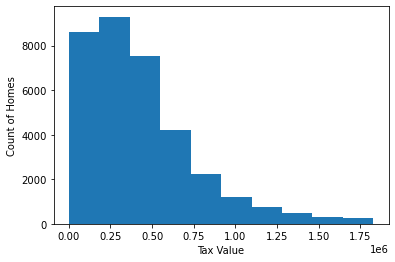

In [12]:
#Visualizing Target Variable
plt.hist(y_train)
plt.xlabel('Tax Value')
plt.ylabel('Count of Homes')
plt.show()

In [13]:
# put y_train and y_validate into dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [14]:
# 1. Predict tax_value_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

In [15]:
# 2. compute tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

In [16]:
# 3. RMSE of tax_value_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  331305.89 
Validate/Out-of-Sample:  334300.07


In [17]:
# 4. RMSE of tax_value_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  339390.26 
Validate/Out-of-Sample:  342949.24


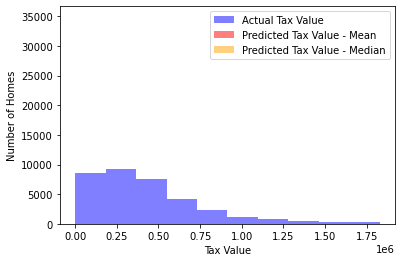

In [18]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_train.tax_value_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Tax Value - Mean")
plt.hist(y_train.tax_value_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Tax Value - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of Homes")
plt.legend()
plt.show()

### Linear Regression

In [19]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to train. Specifying the column in y_train, since we have converted it to a dataframe from a series
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  272435.76647177304 
Validation/Out-of-Sample:  274465.3849924606


#### So far, Linear Regression looks to reduce RMSE in our data

### Lasso-Lars

In [20]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  272436.15952212503 
Validation/Out-of-Sample:  274468.1515795423


### Lasso Lars looks to perform about the same for linear regression

### Generalized Linear Model

In [24]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  272435.76647177304 
Validation/Out-of-Sample:  274465.38499070733


### Polynomial Regression

In [29]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [30]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  271077.013569974 
Validation/Out-of-Sample:  273237.495606614


#### Polynomial features performed the best, so far, without a pointed attempt to select features

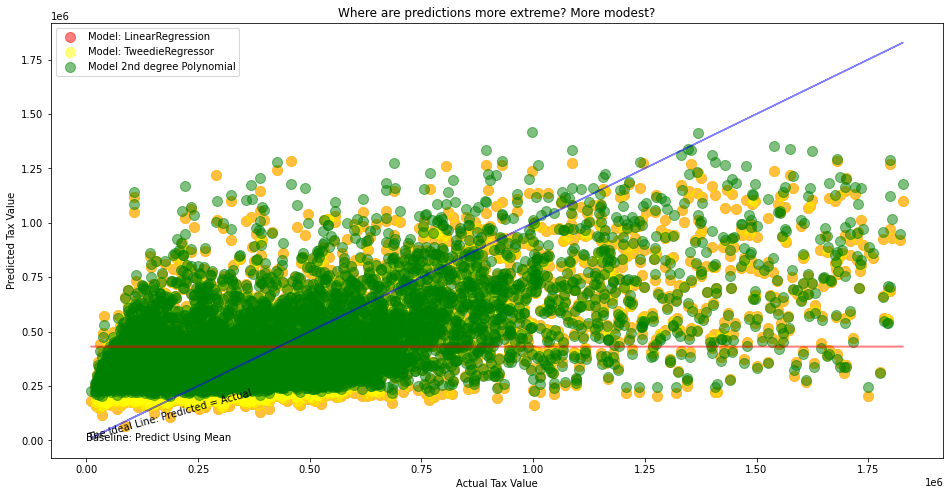

In [31]:
# Plotting Actual vs predicted values
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="red", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

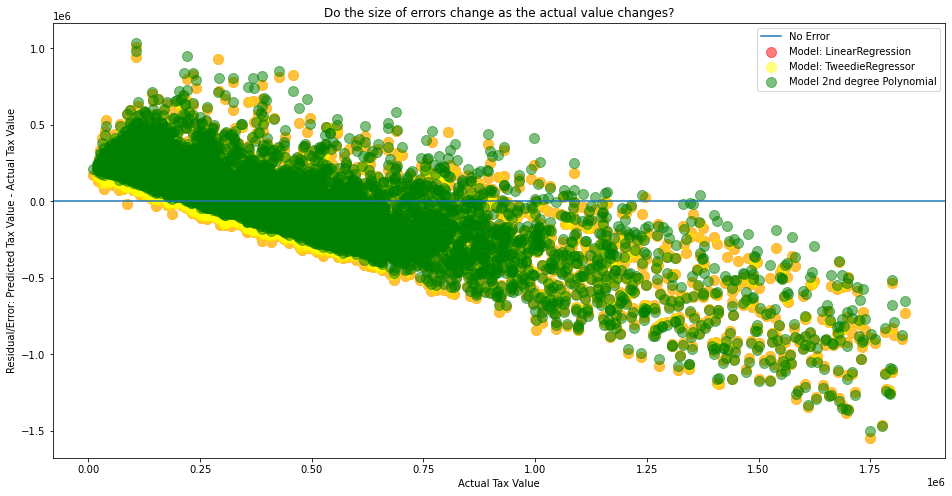

In [32]:
#Residual Plots: Plotting the Errors in Predictions
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2-y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Let's Pivot to examine RFE to improve modeling

In [ ]:
#simple linear model evaluation
lm.coef_, lm.intercept_

In [ ]:
X_train.head(2)

### Using select K Best to evaluate my model

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
# parameters: f_regression stats test, give me 3 features
f_selector = SelectKBest(f_regression, k=3)
# find the top 3 X's correlated with y
f_selector.fit(X_train, y_train)
# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()
# get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()
f_feature

### Using RFE to evaluate my features

In [ ]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

In [ ]:
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')